# Step 1: Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


# Step 2: Load the dataset

In [2]:
file_path = r"C:\Users\cheth\Downloads\updated_dataset.csv"  # Replace with your dataset path
data = pd.read_csv(file_path)

# Step 3: Convert 'fecha_servidor' and 'fecha_esp32' to datetime format for easier manipulation

In [3]:
data['fecha_servidor'] = pd.to_datetime(data['fecha_servidor'], format='%d-%m-%Y %H:%M')
data['fecha_esp32'] = pd.to_datetime(data['fecha_esp32'], format='%d-%m-%Y %H:%M')

# Step 4: Extract relevant columns

In [4]:
data = data[['fecha_servidor', 'energia']]

# Step 5: Set 'fecha_servidor' as the index for time series forecasting

In [5]:
data.set_index('fecha_servidor', inplace=True)

# Step 6: Filter the data to only include rows between 00:00 and 12:00 on 19 August 2021

In [6]:
data = data[(data.index >= '2021-08-19 00:00:00') & (data.index < '2021-08-19 12:00:00')]


# Step 7: Visualize Energy Consumption Over Time

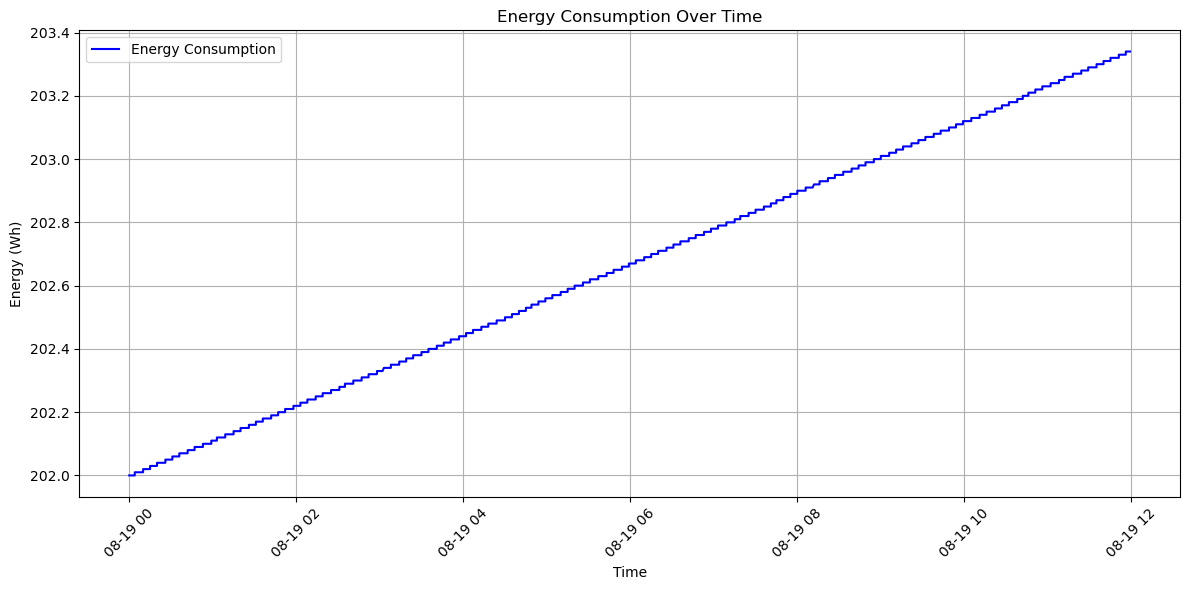

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['energia'], label='Energy Consumption', color='blue')
plt.title('Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy (Wh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Step 8: Visualize Distribution of Energy Consumption

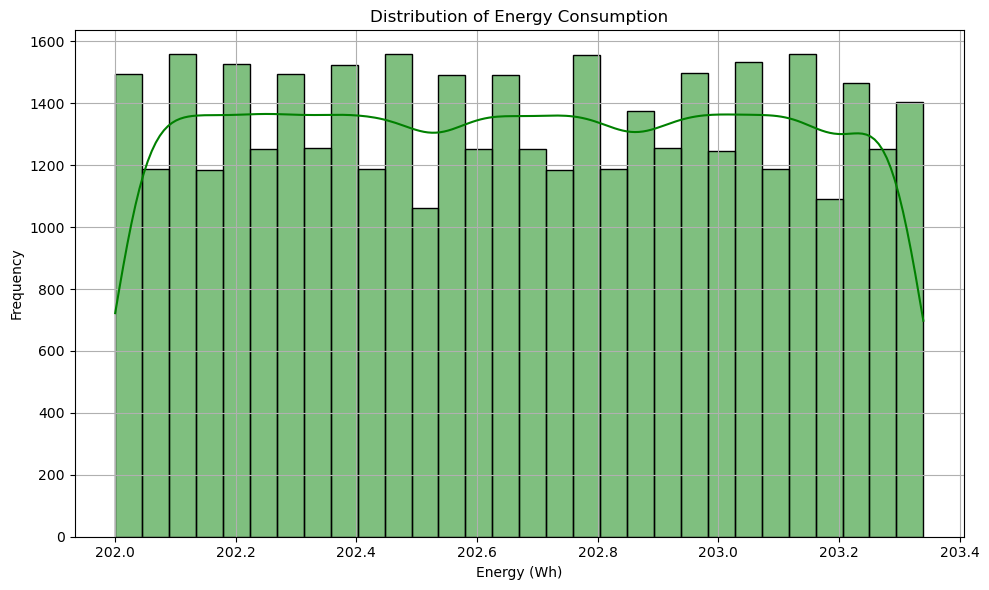

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(data['energia'], kde=True, color='green', bins=30)
plt.title('Distribution of Energy Consumption')
plt.xlabel('Energy (Wh)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

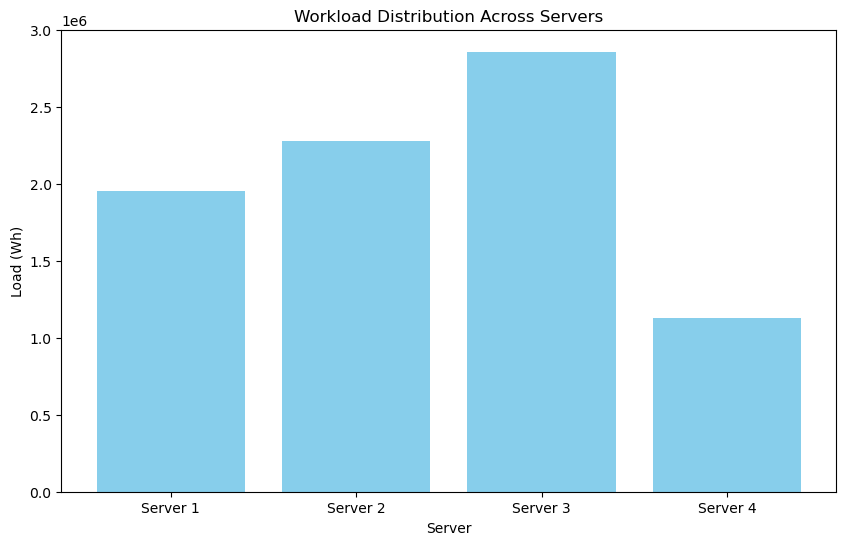

In [31]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (assuming 'data' is already defined and has an 'energia' column)
# Replace 'data' with your actual data as needed
# Example: data = pd.read_csv('your_data.csv') if 'data' is not yet defined
# Assuming 'data' DataFrame has a column 'energia' with energy values
# data = ...

# Define server names and calculate server loads
servers = ['Server 1', 'Server 2', 'Server 3', 'Server 4']
server_loads = np.random.dirichlet(np.ones(4), size=1)[0] * data['energia'].sum()
server_df = pd.DataFrame({'Server': servers, 'Load (Wh)': server_loads})

# Plotting the workload distribution across servers
plt.figure(figsize=(10, 6))
plt.bar(server_df['Server'], server_df['Load (Wh)'], color='skyblue')
plt.title("Workload Distribution Across Servers")
plt.xlabel("Server")
plt.ylabel("Load (Wh)")
plt.show()

# Step 9: ARIMA Model Optimization using auto_arima

In [9]:
print("\nFitting auto_arima model...")
arima_model = auto_arima(data['energia'], seasonal=False, trace=True, suppress_warnings=True, stepwise=True)



Fitting auto_arima model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-490454.279, Time=17.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-490461.382, Time=9.65 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-490459.827, Time=12.76 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-490459.829, Time=13.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-490329.157, Time=5.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-490457.829, Time=15.58 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 74.656 seconds


# Step 10: Fit ARIMA Model

In [10]:
arima_model.fit(data['energia'])

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

# Step 11: Display ARIMA model summary

In [11]:
print("\nARIMA model summary:")
print(arima_model.summary())


ARIMA model summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                40573
Model:               SARIMAX(0, 1, 0)   Log Likelihood              245232.691
Date:                Sat, 26 Oct 2024   AIC                        -490461.382
Time:                        08:31:40   BIC                        -490444.160
Sample:                             0   HQIC                       -490455.934
                              - 40573                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.303e-05   1.25e-14   2.64e+09      0.000     3.3e-05     3.3e-05
sigma2      3.292e-07   1.89e-10   1743.714      0.000    3.29e-07     3.3e-07
Ljung-Box (L1) (Q):           

# Step 12: Get ARIMA Predictions and Residuals

In [12]:
data['arima_pred'] = arima_model.predict_in_sample()
data['residuals'] = data['energia'] - data['arima_pred']

# Step 13: Scaling residuals for LSTM model input

In [13]:
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(data['residuals'].values.reshape(-1, 1))

# Step 14: Creating sequences of residuals for LSTM

In [14]:
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

sequence_length = 24
X, y = create_sequences(residuals_scaled, sequence_length)

# Step 15: Split data into training and testing sets for LSTM

In [15]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# Step 16: Define and train the LSTM model

In [16]:
print("\nDefining LSTM model...")
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, shuffle=False)


Defining LSTM model...


C:\Users\cheth\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 2.7294e-06 - val_loss: 1.2694e-11
Epoch 2/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 1.1432e-10 - val_loss: 6.1016e-11
Epoch 3/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 1.1449e-07 - val_loss: 2.6018e-11
Epoch 4/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 3.0806e-08 - val_loss: 6.3203e-10
Epoch 5/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 1.9866e-08 - val_loss: 1.1151e-08
Epoch 6/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 6.6531e-09 - val_loss: 1.3044e-11
Epoch 7/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 4.4269e-08 - val_loss: 2.1333e-11
Epoch 8/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 9.4154e-11 - val_loss: 5.3833e-10
Epoch 9/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2.0115e-08 - val_loss: 1.3907e-08
Epoch 10/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1.4680e-08 - val_loss: 1.2366e-11
Epoch 11/50
811/811 ━━━━━━━━━━━━━━━━━━━

# Step 17: Predict Residuals using the LSTM model

In [2]:
lstm_residual_pred = lstm_model.predict(X_test)
lstm_residual_pred_inverse = scaler.inverse_transform(lstm_residual_pred)


NameError: name 'lstm_model' is not defined

# Step 18: Predict ARIMA values for the next 12 hours

In [18]:
future_dates = pd.date_range(start='2021-08-19 12:00:00', end='2021-08-19 23:00:00', freq='H')
arima_future_pred = arima_model.predict(n_periods=12)

C:\Users\cheth\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


# Step 19: Combine ARIMA and LSTM residual predictions for hybrid forecasting

In [19]:
combined_pred = arima_future_pred + lstm_residual_pred_inverse.flatten()[:12]

# Step 20: Visualize Combined Predictions

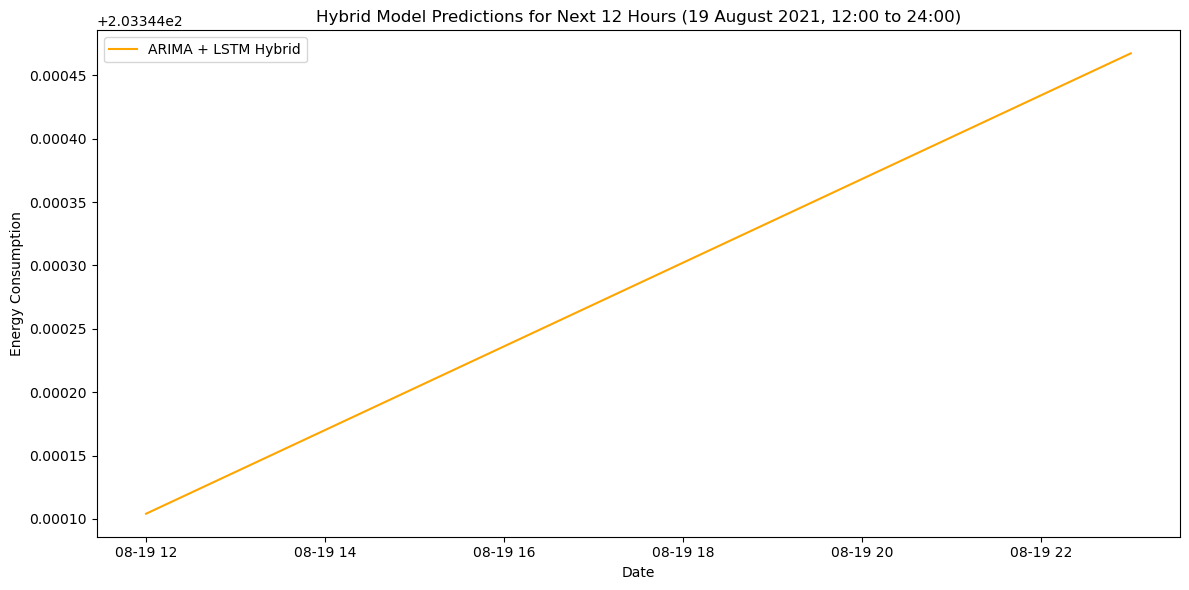

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(future_dates, combined_pred, label='ARIMA + LSTM Hybrid', color='orange')
plt.title('Hybrid Model Predictions for Next 12 Hours (19 August 2021, 12:00 to 24:00)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.tight_layout()
plt.show()

# Step 21: Define y_true for actual energy consumption for the next 12 hours

In [21]:
y_true = data['energia'].values[-12:]  # Last 12 hours of actual data (for comparison)


# Step 22: ARIMA Model Evaluation

In [22]:
print("\nCalculating ARIMA model evaluation metrics...")
arima_pred = arima_future_pred  # ARIMA predictions for the next 12 hours
mse_arima = mean_squared_error(y_true, arima_pred)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(y_true, arima_pred)

arima_metrics_table = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)'],
    'ARIMA': [mse_arima, rmse_arima, mae_arima]
})

print("\nARIMA Model Evaluation Metrics:")
print(arima_metrics_table.to_string(index=False))


Calculating ARIMA model evaluation metrics...

ARIMA Model Evaluation Metrics:
                        Metric        ARIMA
      Mean Squared Error (MSE) 5.908658e-08
Root Mean Squared Error (RMSE) 2.430773e-04
     Mean Absolute Error (MAE) 2.146801e-04


# Step 23: LSTM Model Evaluation

In [1]:
print("\nCalculating LSTM model evaluation metrics...")
lstm_pred = lstm_residual_pred_inverse.flatten()[:12]  # LSTM predictions for residuals (12-hour period)
mse_lstm = mean_squared_error(y_true, lstm_pred)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_true, lstm_pred)

lstm_metrics_table = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)'],
    'LSTM': [mse_lstm, rmse_lstm, mae_lstm]
})

print("\nLSTM Model Evaluation Metrics:")
print(lstm_metrics_table.to_string(index=False))


Calculating LSTM model evaluation metrics...


NameError: name 'lstm_residual_pred_inverse' is not defined

# Step 24: Hybrid Model Evaluation

In [64]:
print("\nCalculating Hybrid model evaluation metrics...")
combined_pred = arima_future_pred + lstm_residual_pred_inverse.flatten()[:12]  # Hybrid model predictions
mse_hybrid = mean_squared_error(y_true, combined_pred)
rmse_hybrid = np.sqrt(mse_hybrid)
mae_hybrid = mean_absolute_error(y_true, combined_pred)

hybrid_metrics_table = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)'],
    'Hybrid': [mse_hybrid, rmse_hybrid, mae_hybrid]
})

print("\nHybrid Model Evaluation Metrics:")
print(hybrid_metrics_table.to_string(index=False))


Calculating Hybrid model evaluation metrics...

Hybrid Model Evaluation Metrics:
                        Metric   Hybrid
      Mean Squared Error (MSE) 0.000018
Root Mean Squared Error (RMSE) 0.004287
     Mean Absolute Error (MAE) 0.004286


# Step 25: Visualize the tables

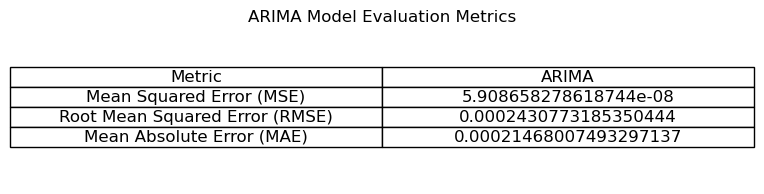

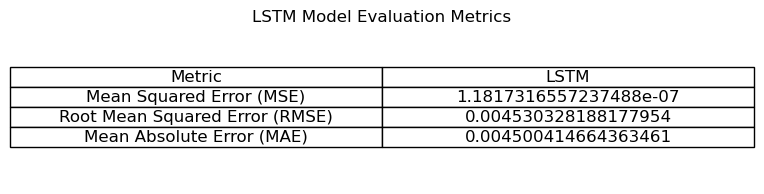

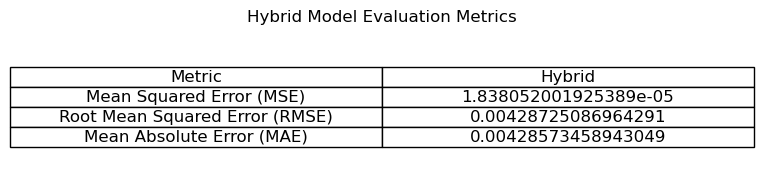

In [65]:
# Step 25: Visualize the tables
def visualize_table(table, title):
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.axis('off')
    ax.axis('tight')
    metrics_table_plot = ax.table(cellText=table.values, colLabels=table.columns, cellLoc='center', loc='center')
    metrics_table_plot.auto_set_font_size(False)
    metrics_table_plot.set_fontsize(12)
    metrics_table_plot.scale(1.2, 1.2)
    plt.title(title)
    plt.show()

# Visualize ARIMA, LSTM, and Hybrid Metrics
visualize_table(arima_metrics_table, 'ARIMA Model Evaluation Metrics')
visualize_table(lstm_metrics_table, 'LSTM Model Evaluation Metrics')
visualize_table(hybrid_metrics_table, 'Hybrid Model Evaluation Metrics')